<a href="https://colab.research.google.com/github/lukasmolnar/RoboCup_NN_Modeling/blob/main/NN_Modeling_ShoulderPitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import copy
from sklearn.metrics import mean_squared_error

In [129]:
# Dataset class and NN architecture

class Dataset(torch.utils.data.Dataset):
  '''
  Prepare the dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
        self.X_orig = copy.deepcopy(X)
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y.reshape(-1, 1))
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

  def __computeStat__(self):
    scaler = StandardScaler()
    scaler.fit(self.X_orig)
    return [scaler.mean_,scaler.scale_]


class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(11, 64),
      nn.ReLU(),
      nn.Linear(64, 32), 
      nn.ReLU(),
      nn.Linear(32, 1)
    )

  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

  def __computeStat__(self):
    scaler = StandardScaler()
    scaler.fit(self.X_orig)
    return [scaler.mean_,scaler.scale_]

In [130]:
# Prepare dataset
data_path_train = '/content/gdrive/MyDrive/NN_Modeling_Dataset/ShoulderPitch/Right/train/'
data_path_test = '/content/gdrive/MyDrive/NN_Modeling_Dataset/ShoulderPitch/Right/test/'

data_columns = ["in_0", "in_1", "in_2", "in_3", "in_4",
                "pos_0", "pos_1", "pos_2", "pos_3", "pos_4",
                "stiffness", "outp"]

dataset_train = pd.DataFrame(columns = data_columns)
dataset_test = pd.DataFrame(columns = data_columns)

In [131]:
# Get training dataset
files = os.listdir(data_path_train)
colnames = ["time", "sensed", "requested", "stiffness"]

print("Found %d files" %(len(files)))

for file in files:
    if file.endswith('.csv'):
      table = pd.read_csv(data_path_train + file, names=colnames)

      data_row = []
      input_row = []
      pos_row = []
      
      for i in range(5, table.shape[0]):
        for k in range(5):
          input_row.append(table['requested'][i-k])
          pos_row.append(table['sensed'][i-(k+1)])

        data_row.append([*input_row, *pos_row, table['stiffness'][i], table['sensed'][i]])
        input_row.clear()
        pos_row.clear()

    dataset_temp = pd.DataFrame(data = data_row, columns = data_columns)
    dataset_train = pd.concat([dataset_train, dataset_temp], ignore_index=True)

dataset_train

Found 8 files


,in_0,in_1,in_2,in_3,in_4,pos_0,pos_1,pos_2,pos_3,pos_4,stiffness,outp
0,67.0,67.0,67.0,67.0,67.0,68.8216,68.8216,68.9095,68.9095,68.9095,70,68.8216
1,67.0,67.0,67.0,67.0,67.0,68.8216,68.8216,68.8216,68.9095,68.9095,70,68.8216
2,67.0,67.0,67.0,67.0,67.0,68.8216,68.8216,68.8216,68.8216,68.9095,70,68.9095
3,67.0,67.0,67.0,67.0,67.0,68.9095,68.8216,68.8216,68.8216,68.8216,70,68.8216
4,67.0,67.0,67.0,67.0,67.0,68.8216,68.9095,68.8216,68.8216,68.8216,70,68.8216
...,...,...,...,...,...,...,...,...,...,...,...,...
18114,37.2,37.6,38.0,38.4,38.8,42.2783,42.6299,43.0694,43.3330,43.7725,60,41.9268
18115,36.8,37.2,37.6,38.0,38.4,41.9268,42.2783,42.6299,43.0694,43.3330,60,41.4873
18116,36.4,36.8,37.2,37.6,38.0,41.4873,41.9268,42.2783,42.6299,43.0694,60,41.1357
18117,36.0,36.4,36.8,37.2,37.6,41.1357,41.4873,41.9268,42.2783,42.6299,60,40.7842


In [132]:
# Get testing dataset
files = os.listdir(data_path_test)
colnames = ["time", "sensed", "requested", "stiffness"]

print("Found %d files" %(len(files)))

for file in files:
    if file.endswith('.csv'):
      table = pd.read_csv(data_path_test + file, names=colnames)

      data_row = []
      input_row = []
      pos_row = []
      
      for i in range(5, table.shape[0]):
        for k in range(5):
          input_row.append(table['requested'][i-k])
          pos_row.append(table['sensed'][i-(k+1)])

        data_row.append([*input_row, *pos_row, table['stiffness'][i], table['sensed'][i]])
        input_row.clear()
        pos_row.clear()

    dataset_temp = pd.DataFrame(data = data_row, columns = data_columns)
    dataset_test = pd.concat([dataset_test, dataset_temp], ignore_index=True)

dataset_test

Found 2 files


,in_0,in_1,in_2,in_3,in_4,pos_0,pos_1,pos_2,pos_3,pos_4,stiffness,outp
0,74.6500,74.8000,74.9500,75.1000,75.2500,77.3471,77.4350,77.6108,77.7866,77.9624,80,77.1713
1,74.5000,74.6500,74.8000,74.9500,75.1000,77.1713,77.3471,77.4350,77.6108,77.7866,80,76.9955
2,74.3500,74.5000,74.6500,74.8000,74.9500,76.9955,77.1713,77.3471,77.4350,77.6108,80,76.8198
3,74.2000,74.3500,74.5000,74.6500,74.8000,76.8198,76.9955,77.1713,77.3471,77.4350,80,76.6440
4,74.0500,74.2000,74.3500,74.5000,74.6500,76.6440,76.8198,76.9955,77.1713,77.3471,80,76.5561
...,...,...,...,...,...,...,...,...,...,...,...,...
5515,47.0000,47.1333,47.2667,47.4000,47.5333,51.2433,51.4191,51.5069,51.5948,51.6827,40,51.0675
5516,46.8667,47.0000,47.1333,47.2667,47.4000,51.0675,51.2433,51.4191,51.5069,51.5948,40,50.8917
5517,46.7333,46.8667,47.0000,47.1333,47.2667,50.8917,51.0675,51.2433,51.4191,51.5069,40,50.7159
5518,46.6000,46.7333,46.8667,47.0000,47.1333,50.7159,50.8917,51.0675,51.2433,51.4191,40,50.5401


In [133]:
# Set fixed random number seed
torch.manual_seed(42)

X_t = dataset_train.iloc[:,:-1].to_numpy()
y_t = dataset_train.iloc[:,-1].to_numpy()

X_v = dataset_test.iloc[:,:-1].to_numpy()
y_v = dataset_test.iloc[:,-1].to_numpy()

# Prepare dataset
data_train = Dataset(X_t, y_t)
data_valid = Dataset(X_v, y_v)

trainloader = DataLoader(data_train, batch_size=128, shuffle=True, num_workers=1)
validloader = DataLoader(data_valid, batch_size=128, num_workers=1)

print('data size :')
print(data_train.X.size())
print('output size :')
print(data_train.y.size())
print('test data size :')
print(data_valid.X.size())
print('output size :')
print(data_valid.y.size())

# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.MSELoss() # nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)


data size :
torch.Size([18119, 11])
output size :
torch.Size([18119, 1])
test data size :
torch.Size([5520, 11])
output size :
torch.Size([5520, 1])


In [134]:
# Train the network
loss_plot = []
valid_plot = []

# Run the training loop
for epoch in range(0, 120):

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Reset loss
    current_loss = 0.0
    valid_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = mlp(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()

    # Compute average loss
    loss_plot.append(current_loss/dataset_train.shape[0])

    for i, data in enumerate(validloader, 0):
        
         # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        outputs = mlp(inputs)
        loss = loss_function(outputs, targets)

        valid_loss += loss.item()

    # Compute average loss
    valid_plot.append(valid_loss/dataset_test.shape[0])

# Process is complete.
print('Training process has finished.')
print('Final training loss: ' + str(current_loss/dataset_train.shape[0]))
print('Final validation loss: ' + str(valid_loss/dataset_test.shape[0]))

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

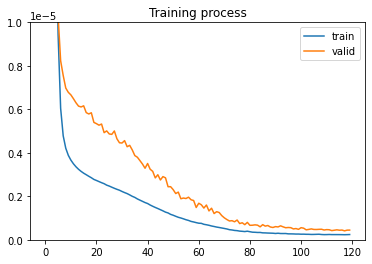

In [135]:
plt.plot(loss_plot, label = 'train')
plt.plot(valid_plot, label = 'valid')
plt.title('Training process')
plt.legend()
plt.ylim([0, 1e-5])
plt.show()

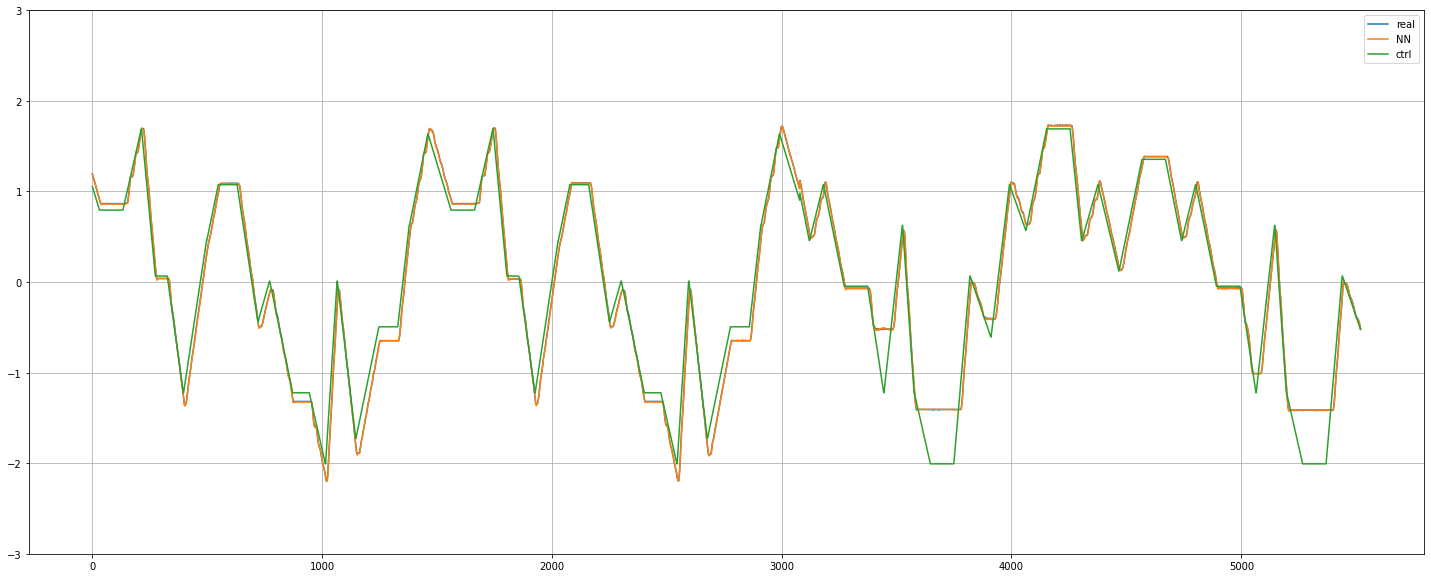

In [136]:
# Plot results for some validation data

plt.figure(figsize=(25,10))

real_trajectory = data_valid.y[:]
predicted_trajectory = mlp(data_valid.X[:,:].float())

requested = data_valid.X[:, 0]

plt.plot(real_trajectory, label="real")
plt.plot(predicted_trajectory.detach().numpy(), label="NN")
plt.plot(requested, label = "ctrl")
plt.legend()
plt.grid()
plt.ylim([-3,3])
plt.show()


Found 2 files
2441 elements


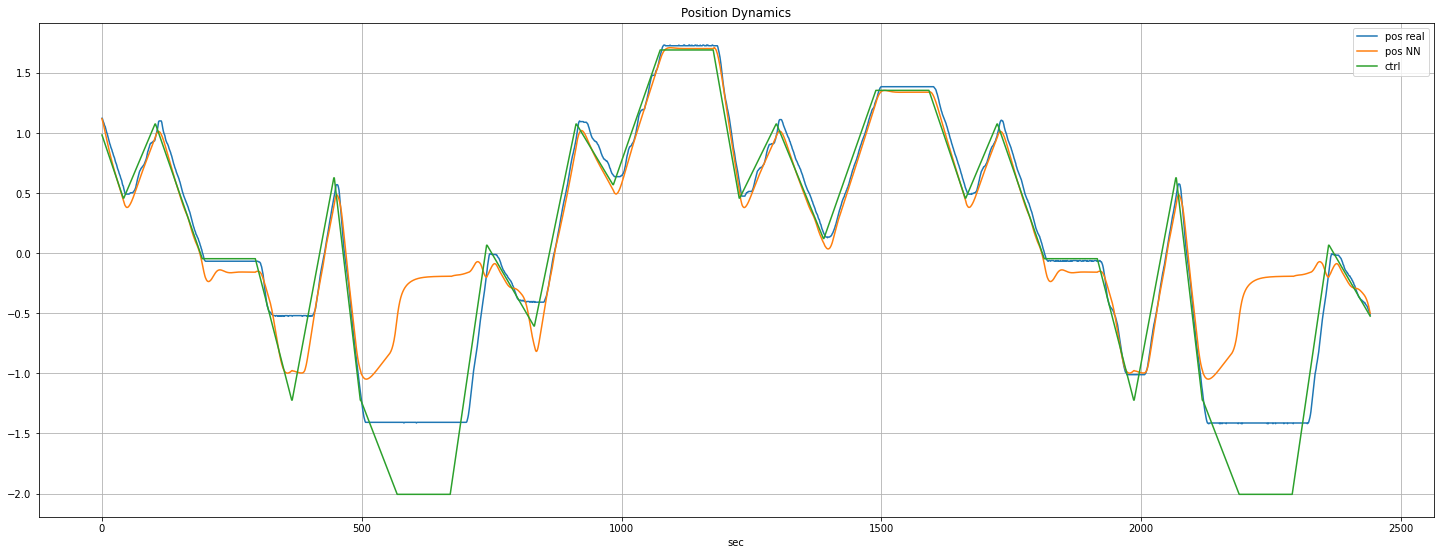

In [139]:
# Full open-loop prediction using model outputs only

files = os.listdir(data_path_test)
colnames = ["time", "sensed", "requested", "stiffness"]

print("Found %d files" %(len(files)))

# Choose one of the validation set files to analyze
file = files[1]

table = pd.read_csv(data_path_test + file, names=colnames)
data_row = []
input_row = []
pos_row = []

for i in range(5, table.shape[0]):
    for k in range(5):
        input_row.append(table['requested'][i-k])
        pos_row.append(table['sensed'][i-(k+1)])

    data_row.append([*input_row, *pos_row, table['stiffness'][i], table['sensed'][i]])
    input_row.clear()
    pos_row.clear()

dataset = pd.DataFrame(data = data_row, columns = data_columns)

ctrl_input = copy.deepcopy(dataset['in_0'].to_numpy())
position_real = copy.deepcopy(dataset['outp'].to_numpy())

features_position = copy.deepcopy(dataset.iloc[:,:-1].to_numpy())

# Scale for validation dataset
[mean_v, scale_v] = data_valid.__computeStat__()

ctrl_input = (ctrl_input - mean_v[0])/scale_v[0] # index of 'in_0'
position_real = (position_real - mean_v[5])/scale_v[5] # index of 'outp'
features_position = (features_position - mean_v)/scale_v

nn_position = []

print("%d elements" %(len(ctrl_input)))

for k in range(len(ctrl_input)):

    pos_out = mlp(torch.tensor(features_position[k,:]).float())
    nn_position.append(pos_out.detach().numpy())

    if True:
        for next in range(5):
            try:
                features_position[k+(1+next), 5+next] = pos_out
            except:
                pass

xs = np.linspace(0,len(ctrl_input), num=len(ctrl_input))

plt.figure(figsize=[25,20])

plt.subplot(2,1,2)
plt.plot(xs, position_real, label="pos real")
plt.plot(xs, nn_position, label="pos NN")
plt.plot(xs, ctrl_input, label = "ctrl")
plt.legend()
plt.grid()
plt.xlabel('sec')
plt.title("Position Dynamics")

plt.show()
